# pca and lda

1. for the attached clean data try to use linear regression applied on features given by PCA
1. select as less as possible features so that the results are comparably good to RMSLE around 0.12
1. experiment with the feature selection
    - has removing indicator or discrete features a positive influence?
    - is the first principal components always the best choice?

In [1]:
import pandas
import numpy
import seaborn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression, RFE

In [2]:
%matplotlib inline

In [3]:
data_file = 'data/data.csv'

Let's see what the data look like.

In [4]:
!head $data_file

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,YrSold,SalePrice,SqrtLotArea,LogLotArea,HasMasVnrArea,SqrtMasVnrArea,LogMasVnrArea,HasBsmtFinSF1,SqrtBsmtFinSF1,LogBsmtFinSF1,HasBsmtFinSF2,SqrtBsmtFinSF2,LogBsmtFinSF2,HasBsmtUnfSF,SqrtBsmtUnfSF,LogBsmtUnfSF,HasTotalBsmtSF,SqrtTotalBsmtSF,LogTotalBsmtSF,Sqrt1stFlrSF,Log1stFlrSF,Has2ndFlrSF,Sqrt2ndFlrSF,Log2ndFlrSF,HasLowQualFinSF,SqrtLowQualFinSF,LogLowQualFinSF,SqrtGrLivArea,LogGrLivArea,HasGarageArea,SqrtGarageArea,LogGarageArea,HasWoodDeckSF,SqrtWoodDeckSF,LogWoodDeckSF,HasOpenPorchSF,SqrtOpenPorchSF,LogOpenPorchSF,HasPoolArea,SqrtPoolArea,LogPoolArea,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZo

Drop 'Unnamed: 0' columns and set 'Id' as index.

In [5]:
data = pandas.read_csv(data_file, index_col='Id')
data = data.drop(['Unnamed: 0'], axis=1)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 326 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(32), int64(294)
memory usage: 3.6 MB


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


See if the data are really clean.

In [6]:
data.isnull().sum().sum()

0

In [7]:
df_tr, df_te = train_test_split(data, test_size=0.25, random_state=17)
X = df_tr.drop(['SalePrice'], axis=1)
X_te = df_te.drop(['SalePrice'], axis=1)
y = df_tr['SalePrice']
y_te = df_te['SalePrice']

The SalePrice is already corrected to normal distribution.

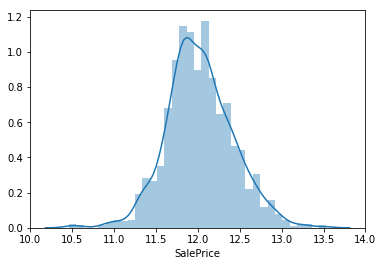

In [8]:
seaborn.distplot(data['SalePrice'])

## baseline

Try to reproduce result from third tutorial. It is important to make same test and train split with random state of value 17.

In [9]:
columns = ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'HasBsmtFinSF2',
       'HasTotalBsmtSF', 'HasGarageArea', 'BldgType_1Fam', 'BldgType_2fmCon',
       'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'BsmtQual_0',
       'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA',
       'BsmtCond_0', 'BsmtExposure_0', 'BsmtExposure_Gd', 'BsmtFinType1_0',
       'BsmtFinType1_ALQ', 'BsmtFinType1_GLQ', 'BsmtFinType2_Unf',
       'CentralAir_N', 'CentralAir_Y', 'KitchenQual_Ex', 'KitchenQual_Fa',
       'KitchenQual_Gd', 'KitchenQual_TA', 'GarageType_0', 'GarageFinish_0',
       'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf',
       'GarageQual_0', 'GarageCond_0']
X = df_tr[columns]
X_te = df_te[columns]
X.shape, X_te.shape

((1095, 37), (365, 37))

In [10]:
scaler = StandardScaler()
float_columns = ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
scaler.fit(X[float_columns])

X.loc[:, float_columns] = scaler.transform(X[float_columns])
X_te.loc[:, float_columns] = scaler.transform(X_te[float_columns])

/home/podondra/mi-pdd/venv/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
clf = LinearRegression()
clf.fit(X, y)
numpy.sqrt(mean_squared_error(clf.predict(X_te), y_te))

0.16323001845823623

## pca

Use PCA to transform features. Hereafter the feature obtained from PCA will be used.

In [12]:
X = df_tr.drop(['SalePrice'], axis=1)
X_te = df_te.drop(['SalePrice'], axis=1)
pca = PCA()
X = pca.fit_transform(X)
X_te = pca.transform(X_te)

Cumulative sum shows that a few features can explain all variance. The first component explains more than 98% of all variance.

In [13]:
numpy.cumsum(pca.explained_variance_ratio_)

array([ 0.9875011 ,  0.99198839,  0.99491899,  0.99721524,  0.99864754,
        0.99907533,  0.9993366 ,  0.99955073,  0.99971236,  0.99982809,
        0.9998652 ,  0.9998944 ,  0.9999217 ,  0.99994501,  0.99996162,
        0.99997517,  0.9999835 ,  0.99999162,  0.99999683,  0.99999851,
        0.99999924,  0.99999943,  0.99999951,  0.99999959,  0.99999965,
        0.99999971,  0.99999976,  0.9999998 ,  0.99999983,  0.99999986,
        0.99999988,  0.99999988,  0.99999989,  0.9999999 ,  0.9999999 ,
        0.99999991,  0.99999991,  0.99999992,  0.99999992,  0.99999992,
        0.99999992,  0.99999993,  0.99999993,  0.99999993,  0.99999993,
        0.99999993,  0.99999994,  0.99999994,  0.99999994,  0.99999994,
        0.99999994,  0.99999995,  0.99999995,  0.99999995,  0.99999995,
        0.99999995,  0.99999995,  0.99999995,  0.99999996,  0.99999996,
        0.99999996,  0.99999996,  0.99999996,  0.99999996,  0.99999996,
        0.99999996,  0.99999997,  0.99999997,  0.99999997,  0.99

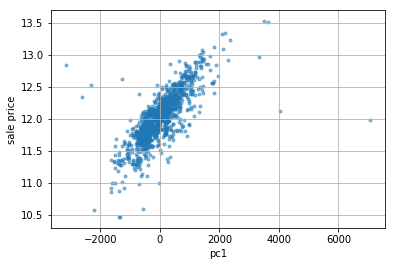

In [14]:
pyplot.scatter(X[:, 1], y, marker='.', alpha=0.5)
pyplot.xlabel('pc1')
pyplot.ylabel('sale price')
pyplot.grid()

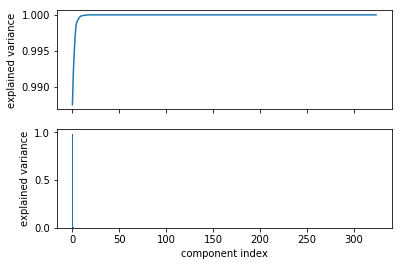

In [15]:
fig, (ax1, ax2) = pyplot.subplots(nrows=2, sharex=True)
ax1.plot(numpy.cumsum(pca.explained_variance_ratio_))
ax2.bar(numpy.arange(pca.n_components_), pca.explained_variance_ratio_)
ax2.set_xlabel('component index')
for ax in ax1, ax2:
    ax.set_ylabel('explained variance')

Use linear regression for increasing number of principal components included in features given to it.

In [16]:
rmsles = numpy.zeros(pca.n_components_)
for components in range(1, pca.n_components_ + 1):
    # evaluate linear regression
    clf = LinearRegression()
    clf.fit(X[:, :components], y)
    rmsles[components - 1] = numpy.sqrt(mean_squared_error(clf.predict(X_te[:, :components]), y_te))

Only for first 270 the result is reasonable.

In [17]:
reasonable = 270
rmsles[:reasonable]

array([ 0.3802472 ,  0.21781312,  0.21731592,  0.21287837,  0.21223035,
        0.21046961,  0.21043923,  0.20799312,  0.20281856,  0.20172175,
        0.19868312,  0.19878116,  0.19867657,  0.19888151,  0.197469  ,
        0.19771176,  0.19759091,  0.19748966,  0.16622964,  0.16721276,
        0.16569035,  0.16257284,  0.16258953,  0.1625915 ,  0.16254302,
        0.16358763,  0.16388133,  0.16111735,  0.16099353,  0.16281597,
        0.16317173,  0.15357369,  0.15199754,  0.13017691,  0.13006103,
        0.12984849,  0.12975767,  0.12959937,  0.12720304,  0.12716912,
        0.12714826,  0.12724775,  0.12725059,  0.12725202,  0.12717588,
        0.1278786 ,  0.12818847,  0.12812974,  0.12817903,  0.12809641,
        0.1280278 ,  0.12759067,  0.12790158,  0.12797014,  0.12797198,
        0.12812721,  0.1278682 ,  0.12830043,  0.12789238,  0.1273078 ,
        0.12742324,  0.12700404,  0.12700859,  0.12772699,  0.12741645,
        0.12712191,  0.12691366,  0.12690494,  0.126702  ,  0.12

In [18]:
rmsles[270:]

array([   37861.39282989,   891933.06047349,  5896035.85304205,
        7642155.56323879,  4728534.34639997,  3770159.5945227 ,
        4260633.88264444,  4217537.00331617,  4013541.33677028,
        4644727.67060017,  7077263.15048093,  6113119.7760115 ,
        7488005.56810639,  7488005.56810424,  4154792.14225471,
        2836119.01862223,  2725500.15489129,  1915626.67697034,
        2069084.30570338,  1622452.56737225,  1622452.56738434,
        1256662.18803097,  1660971.73614806,  2038973.15735037,
        2209799.84954272,  5014341.90262042,   981834.31040509,
        1480092.01600105,   364119.50892454,  1741003.93371873,
        2365838.62761732,  1661363.86967515,  1661363.86971933,
        1694250.54715852,  1192906.92626881,   210039.55051788,
         429391.92469534,   683754.60855891,  1405252.66774811,
        1583303.52358204,  2695994.16956852,  2909838.30246954,
        3225522.13999646,  1230019.54256152,  1113792.18218354,
         954234.58967701,   647032.46862

The best result is for first 216 principal components.

In [19]:
numpy.argmin(rmsles) + 1, numpy.min(rmsles)

(216, 0.11727733440522341)

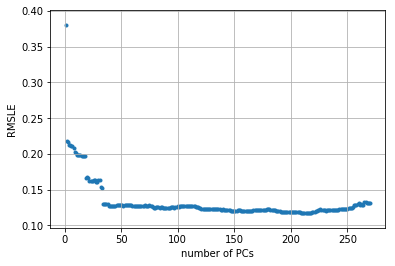

In [20]:
pyplot.scatter(range(1, pca.n_components_ + 1)[:reasonable], rmsles[:reasonable], marker='.')
pyplot.grid()
pyplot.ylabel('RMSLE')
pyplot.xlabel('number of PCs')

## remove discrete features

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 326 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(32), int64(294)
memory usage: 3.6 MB


In [22]:
data_float = data.select_dtypes(include=['float64'])
df_tr, df_te = train_test_split(data_float, test_size=0.25, random_state=17)

X = df_tr.drop(['SalePrice'], axis=1)
X_te = df_te.drop(['SalePrice'], axis=1)

pca = PCA()
X = pca.fit_transform(X)
X_te = pca.transform(X_te)

In [23]:
len(df_tr.columns)

32

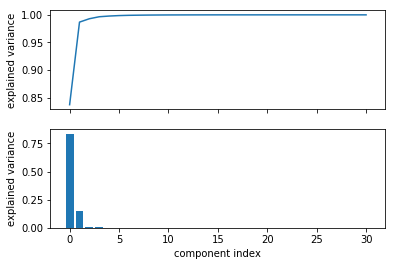

In [24]:
fig, (ax1, ax2) = pyplot.subplots(nrows=2, sharex=True)
ax1.plot(numpy.cumsum(pca.explained_variance_ratio_))
ax2.bar(numpy.arange(pca.n_components_), pca.explained_variance_ratio_)
ax2.set_xlabel('component index')
for ax in ax1, ax2:
    ax.set_ylabel('explained variance')

In [25]:
rmsles = numpy.zeros(pca.n_components_)
for components in range(1, pca.n_components_ + 1):
    # evaluate linear regression
    clf = LinearRegression()
    clf.fit(X[:, :components], y)
    rmsles[components - 1] = numpy.sqrt(mean_squared_error(clf.predict(X_te[:, :components]), y_te))
rmsles

array([ 0.38244406,  0.34724447,  0.33662012,  0.31915734,  0.31658574,
        0.30999752,  0.21257418,  0.21041995,  0.21094305,  0.19678426,
        0.1942802 ,  0.19354666,  0.1907478 ,  0.19114909,  0.19136873,
        0.19099085,  0.1914087 ,  0.18734285,  0.18810919,  0.18548345,
        0.18547313,  0.1845619 ,  0.18657063,  0.18661693,  0.18633987,
        0.18613803,  0.18593606,  0.18348403,  0.17881212,  0.1769557 ,
        0.17758495])

In [26]:
rmsles.min(), rmsles.argmin() + 1

(0.17695569504316064, 30)

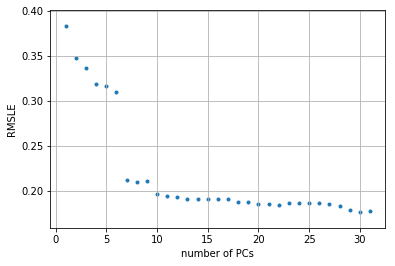

In [27]:
pyplot.scatter(range(1, pca.n_components_ + 1), rmsles, marker='.')
pyplot.grid()
pyplot.ylabel('RMSLE')
pyplot.xlabel('number of PCs')

The result without discrete features after PCA application is worse than on raw data.

## removing indicators

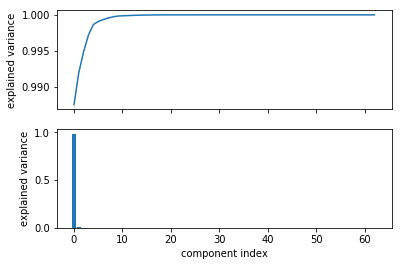

In [28]:
data_rich = data.drop(data.columns[data.nunique() <= 2], axis=1)
df_tr, df_te = train_test_split(data_rich, test_size=0.25, random_state=17)

X = df_tr.drop(['SalePrice'], axis=1)
X_te = df_te.drop(['SalePrice'], axis=1)

pca = PCA()
X = pca.fit_transform(X)
X_te = pca.transform(X_te)

fig, (ax1, ax2) = pyplot.subplots(nrows=2, sharex=True)
ax1.plot(numpy.cumsum(pca.explained_variance_ratio_))
ax2.bar(numpy.arange(pca.n_components_), pca.explained_variance_ratio_)
ax2.set_xlabel('component index')
for ax in ax1, ax2:
    ax.set_ylabel('explained variance')

In [29]:
len(df_tr.columns)

64

In [30]:
rmsles = numpy.zeros(pca.n_components_)
for components in range(1, pca.n_components_ + 1):
    # evaluate linear Regression
    clf = LinearRegression()
    clf.fit(X[:, :components], y)
    rmsles[components - 1] = numpy.sqrt(mean_squared_error(clf.predict(X_te[:, :components]), y_te))
rmsles

array([ 0.3802472 ,  0.21781354,  0.21731635,  0.2128788 ,  0.21223075,
        0.21047018,  0.21043981,  0.20799389,  0.20281986,  0.20172318,
        0.19868637,  0.1987847 ,  0.19868036,  0.19888534,  0.19747321,
        0.1977164 ,  0.197596  ,  0.19749654,  0.16625872,  0.16724059,
        0.16572128,  0.16257578,  0.16258377,  0.16263944,  0.16258724,
        0.16365063,  0.16396399,  0.16138171,  0.16127186,  0.16310387,
        0.16371003,  0.15970164,  0.14779837,  0.13204239,  0.13205111,
        0.13057754,  0.13073882,  0.13088791,  0.13080792,  0.13055598,
        0.1301264 ,  0.12992815,  0.13012523,  0.12977867,  0.12995299,
        0.12995112,  0.12995042,  0.13019345,  0.13060619,  0.12948126,
        0.1293274 ,  0.12763306,  0.12761926,  0.12750719,  0.12775252,
        0.12780133,  0.12752995,  0.12738328,  0.12725287,  0.12731588,
        0.12702606,  0.12702606,  0.12702606])

In [31]:
rmsles.min(), rmsles.argmin() + 1

(0.12702605501699113, 61)

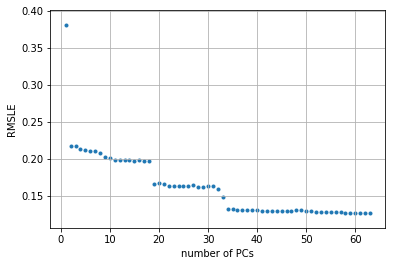

In [32]:
pyplot.scatter(range(1, pca.n_components_ + 1), rmsles, marker='.')
pyplot.grid()
pyplot.ylabel('RMSLE')
pyplot.xlabel('number of PCs')

Result without indicators is also almost as good as with all PCA features but it uses much only 61 features.

## feature selection

select as less as possible features

In [33]:
df_tr, df_te = train_test_split(data, test_size=0.25, random_state=17)
X = df_tr.drop(['SalePrice'], axis=1)
X_te = df_te.drop(['SalePrice'], axis=1)
pca = PCA()
X = pca.fit_transform(X)
X_te = pca.transform(X_te)

### univariate feature selection

#### f-test

In [34]:
rmsles = numpy.zeros(pca.n_components_)
for k in range(1, pca.n_components_ + 1):
    kbest = SelectKBest(f_regression, k=k)
    X_new = kbest.fit_transform(X, y)
    X_te_new = kbest.transform(X_te)
    clf = LinearRegression()
    clf.fit(X_new, y)
    rmsles[k - 1] = numpy.sqrt(mean_squared_error(clf.predict(X_te_new), y_te))
rmsles.argmin() + 1, rmsles.min()

(46, 0.12423298116253431)

(0, 0.5)

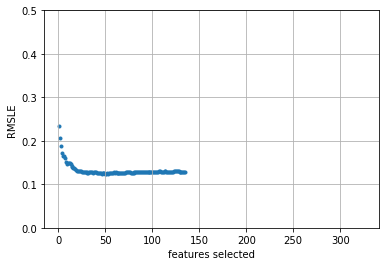

In [35]:
pyplot.scatter(range(1, pca.n_components_ + 1), rmsles, marker='.')
pyplot.grid()
pyplot.ylabel('RMSLE')
pyplot.xlabel('features selected')
pyplot.ylim(bottom=0, top=0.5)

In [36]:
kbest = SelectKBest(f_regression, k=46)
X_new = kbest.fit_transform(X, y)
X_te_new = kbest.transform(X_te)
clf = LinearRegression()
clf.fit(X_new, y)
numpy.sqrt(mean_squared_error(clf.predict(X_te_new), y_te))

0.12423298116253431

Principal components selected.

In [37]:
pandas.Series(kbest.pvalues_).nsmallest(46)

1      1.121466e-200
18      3.537404e-24
0       1.367344e-16
33      3.118779e-16
8       1.588937e-05
21      1.859706e-04
7       1.997632e-04
31      3.459629e-04
10      5.597575e-04
4       1.353227e-03
29      1.438502e-02
27      2.104405e-02
77      3.088920e-02
2       3.268683e-02
20      3.798024e-02
9       3.871748e-02
19      3.972590e-02
32      4.062324e-02
38      4.774559e-02
11      7.597593e-02
14      9.074228e-02
16      9.139731e-02
25      9.371271e-02
260     1.142463e-01
3       1.283447e-01
78      1.886342e-01
56      2.044750e-01
221     2.130959e-01
116     2.244030e-01
181     2.543902e-01
72      2.604215e-01
102     2.886112e-01
266     3.054223e-01
107     3.108734e-01
93      3.120679e-01
57      3.251932e-01
59      3.288977e-01
200     3.313249e-01
83      3.395976e-01
99      3.598419e-01
118     3.611264e-01
37      3.618074e-01
174     3.695772e-01
76      3.755943e-01
44      3.844368e-01
164     3.848721e-01
dtype: float64

### recursive feature elimination

In [38]:
# remove indicators
data_ = data.drop(data.columns[data.nunique() <= 2], axis=1)
df_tr, df_te = train_test_split(data_, test_size=0.25, random_state=17)
X = df_tr.drop(['SalePrice'], axis=1)
y = df_tr['SalePrice']
X_te = df_te.drop(['SalePrice'], axis=1)
y_te = df_te['SalePrice']
pca = PCA()
X = pca.fit_transform(X)
X_te = pca.transform(X_te)

In [39]:
data_.shape, data.shape

((1460, 64), (1460, 326))

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_te_scaled = scaler.transform(X_te)

In [41]:
X_scaled.std(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [42]:
X_scaled.mean(axis=0)

array([  3.24448738e-18,   1.29779495e-17,  -2.92003864e-17,
        -3.24448738e-18,   9.73346213e-18,  -1.21668277e-17,
        -8.92234029e-18,   1.94669243e-17,  -1.94669243e-17,
         8.11121844e-18,   6.48897476e-18,  -3.24448738e-18,
         0.00000000e+00,  -1.78446806e-17,   1.29779495e-17,
        -6.48897476e-18,  -1.13557058e-17,  -3.24448738e-18,
        -9.73346213e-18,   3.24448738e-18,   3.24448738e-18,
        -8.11121844e-19,   3.08226301e-17,   8.11121844e-18,
         1.29779495e-17,  -2.02780461e-18,  -1.29779495e-17,
        -1.29779495e-17,   8.11121844e-18,   6.48897476e-18,
        -2.75781427e-17,   1.62224369e-18,   3.24448738e-18,
         9.73346213e-18,   1.29779495e-17,  -1.29779495e-17,
        -8.11121844e-18,   9.73346213e-18,   0.00000000e+00,
        -1.62224369e-17,   1.62224369e-17,   2.55503381e-17,
        -1.21668277e-17,   3.24448738e-18,   1.29779495e-17,
         1.13557058e-17,   2.19002898e-17,   4.05560922e-18,
        -8.11121844e-18,

In [43]:
clf = LinearRegression()
clf.fit(X_scaled, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

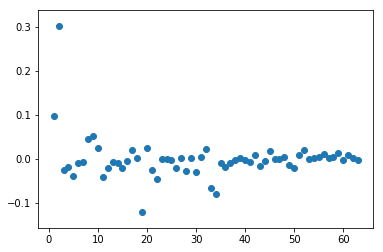

In [44]:
pyplot.scatter(range(1, len(clf.coef_) + 1), clf.coef_)

In [45]:
numpy.sqrt(mean_squared_error(clf.predict(X_te_scaled), y_te))

0.12712236837495627

In [46]:
rmsles = list()
for k in range(1, X.shape[1] + 1):
    clf = LinearRegression()
    rfe = RFE(estimator=clf, n_features_to_select=k, step=1)
    rfe.fit(X, y)
    clf.fit(rfe.transform(X), y)
    rmsles.append(numpy.sqrt(mean_squared_error(clf.predict(rfe.transform(X_te)), y_te)))    
    print(k, rmsles[-1])

1 0.39652084453
2 0.395417973306
3 0.395421284336
4 0.395452652642
5 0.395235422675
6 0.393783921919
7 0.393803962641
8 0.393832733814
9 0.387907547886
10 0.38668697343
11 0.386028648664
12 0.378518794824
13 0.378764654278
14 0.378551932261
15 0.379154600204
16 0.377852334409
17 0.377733829477
18 0.377810403019
19 0.377864393708
20 0.377917951178
21 0.37700044871
22 0.377845762364
23 0.377812390305
24 0.377660604164
25 0.375520436784
26 0.375726609439
27 0.367593806453
28 0.367785926436
29 0.367503664443
30 0.347564123401
31 0.34750470952
32 0.347765113394
33 0.347847717198
34 0.345444281269
35 0.345460289256
36 0.345464766727
37 0.348633445991
38 0.34822093283
39 0.348133951571
40 0.34781713928
41 0.347137068585
42 0.344555074302
43 0.341641279977
44 0.173014695823
45 0.165199285478
46 0.164245098476
47 0.164196030002
48 0.158215301047
49 0.153533008396
50 0.153530956881
51 0.152547779453
52 0.15259367808
53 0.15234202209
54 0.15247422188
55 0.149499170403
56 0.149498392307
57 0.14601

In [47]:
rmsles = numpy.array(rmsles)
rmsles.min(), rmsles.argmin() + 1

(0.12702605501699107, 61)

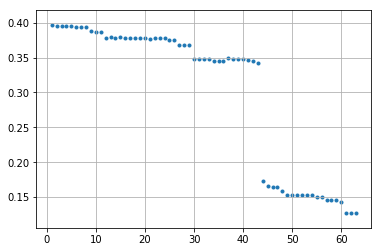

In [48]:
pyplot.scatter(range(1, X.shape[1] + 1), rmsles, marker='.')
pyplot.grid()

With recursive approach score is not as good as with f-test approach.

## Conclusion

### for the attached clean data try to use linear regression applied on features given by PCA

For first 216 PCs RMSLE is 0.11727733440522341.

### select as less as possible features so that the results are comparably good to RMSLE around 0.12

With univariate feature selection (f-test) it can select 46 PCs with RMSLE 0.12423298116253431.

### has removing indicator or discrete features a positive influence

Removing indicator or discrete features does not have positive influence in case of this selection.
The RMSLE 0.11727733440522341 was also obtained with discrete features and indicators included.

### is the first principal components always the best choice?

In the results with RMSLE 0.11727733440522341 and 0.12423298116253431 the first PC is included
so I consider it important.